# Prediction of Sale Price

## Objective 
Develop and assess a regression model to predict SalePrice, addressing Business Requirement 2.

## Inputs
outputs/datasets/collection/HousePrices.csv

## Outputs
Train set (features and target)
Test set (features and target)
Data cleaning and feature engineering pipeline
Features importance plot

## CRISP-DM
Modelling and evaluation.


# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspaces/Heritage-Housing/jupyter_notebooks'

We want to make the child of the current directory the new current directory
* os.chdir() defines the new current directory

In [2]:
os.chdir('/workspaces/Heritage-Housing')
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspaces/Heritage-Housing'

## Load Data

In [4]:
import pandas as pd
%matplotlib inline
train_set_path = "outputs/datasets/cleaned/clean_set.csv"
df = pd.read_csv(train_set_path)
df.head(3)

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,...,KitchenQual,LotArea,LotFrontage,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,548,RFn,2003.0,...,Gd,8450,65.0,61,5,7,856,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,460,RFn,1976.0,...,TA,9600,80.0,0,8,6,1262,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,608,RFn,2001.0,...,Gd,11250,68.0,42,5,7,920,2001,2002,223500


## Machine Learning Pipline

* We first create a ML pipine for our Data Cleaning and Feature engineering 

In [5]:
from sklearn.pipeline import Pipeline

### Feature Engineering
from feature_engine import transformation as vt
from feature_engine.encoding import OrdinalEncoder
from feature_engine.selection import SmartCorrelatedSelection

### Feat Scaling
from sklearn.preprocessing import StandardScaler

### Feat Selection
from sklearn.feature_selection import SelectFromModel

### ML algorithms
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor


selection_method = "variance"
corr_method = "spearman"

def PipelineOptimization(model):
    pipeline_base = Pipeline([

        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                    variables=['BsmtExposure',
                                                                'BsmtFinType1',
                                                                'GarageFinish',
                                                                'KitchenQual'])),

        ("NumericLogTransform", vt.LogTransformer(variables=['1stFlrSF',
                                                            'LotArea',
                                                            'GrLivArea','LotFrontage'])),
        ("NumericPowerTransform", vt.PowerTransformer(variables=['TotalBsmtSF','OpenPorchSF'])),
        ("NumericYeoJohnsonTransform",
        vt.YeoJohnsonTransformer(variables=['TotalBsmtSF'])),

        ("SmartCorrelatedSelection",
        SmartCorrelatedSelection(variables=None,
                                    method=corr_method,
                                    threshold=0.8,
                                    selection_method=selection_method
                                    )),

        ("feat_scaling", StandardScaler()),

        ("feat_selection",  SelectFromModel(model)),

        ("model", model),

    ])

    return pipeline_base

**Hyperparameter Optimization**

In [6]:
from sklearn.model_selection import GridSearchCV
import numpy as np

class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")

            model = PipelineOptimization(self.models[key])
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                            verbose=verbose, scoring=scoring, )
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)
        columns = ['estimator', 'min_score',
                'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]
        return df[columns], self.grid_searches

**Split the Training and testing set**

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
                                        df.drop(['SalePrice'], axis=1),
                                        df['SalePrice'],
                                        test_size = 0.2,
                                        random_state = 0,
                                        )

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1168, 20) (1168,) (292, 20) (292,)


### Grid Search CV - Sklearn

In [8]:
models_quick_search = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
}

params_quick_search = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
}


In [9]:

search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)



Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is 


Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is 


Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is 


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is 

In [10]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
3,ExtraTreesRegressor,0.687809,0.819848,0.864335,0.066621
0,LinearRegression,0.728158,0.807558,0.855802,0.04733
2,RandomForestRegressor,0.688819,0.770973,0.817628,0.04748
1,DecisionTreeRegressor,0.494971,0.579547,0.667303,0.063698


### Extensive Search

In [11]:
models_search = {
    "RandomForestRegressor":RandomForestRegressor(random_state=0),
    "LinearRegression": LinearRegression(),
    "ExtraTreesRegressor":ExtraTreesRegressor(random_state=0)

}

params_search = {
    "RandomForestRegressor":{
        'model__n_estimators': [100,700],
        'model__max_depth': [6,18,None],
    },
    
    "LinearRegression":{},

    "ExtraTreesRegressor":{'model__n_estimators': [100,50,150],
                        'model__max_depth': [None, 3 ,15],
                        'model__min_samples_split': [2, 50],
                        'model__min_samples_leaf': [1, 50],
                        }
}

In [12]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 6 candidates, totalling 30 fits


/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is 


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is 


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 36 candidates, totalling 180 fits


/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is 

In [13]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__n_estimators,model__min_samples_leaf,model__min_samples_split
8,ExtraTreesRegressor,0.704606,0.822258,0.859771,0.059228,None,50,1,2
7,ExtraTreesRegressor,0.687809,0.819848,0.864335,0.066621,None,100,1,2
9,ExtraTreesRegressor,0.69008,0.819544,0.865691,0.065412,None,150,1,2
36,ExtraTreesRegressor,0.762416,0.815853,0.853106,0.038874,15,150,1,50
12,ExtraTreesRegressor,0.762187,0.815833,0.853234,0.038962,None,150,1,50
33,ExtraTreesRegressor,0.679856,0.815207,0.867005,0.068832,15,150,1,2
34,ExtraTreesRegressor,0.760013,0.814748,0.852223,0.039479,15,100,1,50
10,ExtraTreesRegressor,0.759661,0.814613,0.851899,0.039516,None,100,1,50
31,ExtraTreesRegressor,0.676688,0.814008,0.867144,0.069934,15,100,1,2
35,ExtraTreesRegressor,0.762338,0.813599,0.852982,0.039672,15,50,1,50


### Best Model

In [14]:
best_model = grid_search_summary.iloc[0,0]
best_model

'ExtraTreesRegressor'

In [15]:
best_parameters = grid_search_pipelines[best_model].best_params_
best_parameters

{'model__max_depth': None,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 2,
 'model__n_estimators': 50}

In [16]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['BsmtExposure', 'BsmtFinType1',
                                           'GarageFinish', 'KitchenQual'])),
                ('NumericLogTransform',
                 LogTransformer(variables=['1stFlrSF', 'LotArea', 'GrLivArea',
                                           'LotFrontage'])),
                ('NumericPowerTransform',
                 PowerTransformer(variables=['TotalBsmtSF', 'OpenPorchSF'])),
                ('Nume...eoJohnsonTransform',
                 YeoJohnsonTransformer(variables=['TotalBsmtSF'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance')),
                ('feat_scaling', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=ExtraTreesRegressor(random_state=0))),
                ('model',
                 ExtraTreesRegressor(n_estimators=50, random_state=0))])

### Assess Feature Importance

/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is 

* These are the 5 most important features in descending order. The model was trained on them: 
['GarageArea', 'GrLivArea', 'OverallQual', 'TotalBsmtSF', 'YearBuilt']


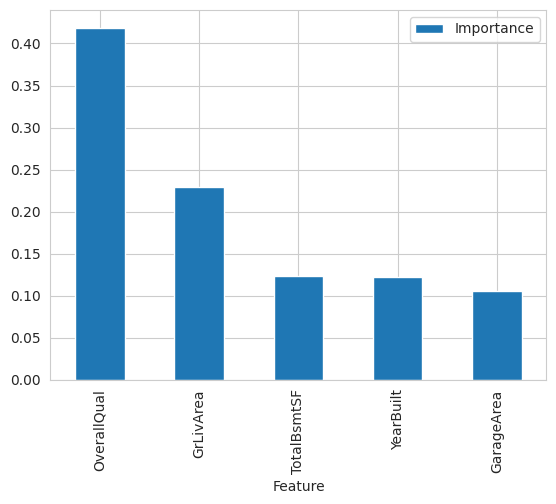

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

%matplotlib inline

# after data cleaning and feat engine, the feature may space changes
data_cleaning_feat_eng_steps = 5 # how many data cleaning and feature engineering does your pipeline have?
columns_after_data_cleaning_feat_eng = (Pipeline(best_regressor_pipeline.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support()].to_list()

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
          'Feature': columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support()],
          'Importance': best_regressor_pipeline['model'].feature_importances_})
  .sort_values(by='Importance', ascending=False)
  )

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{best_features}")

df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.show()

### Evaluate Pipeline on Train and Test Sets

In [18]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np


def regression_performance(X_train, y_train, X_test, y_test, pipeline):
    print("Model Evaluation \n")
    print("* Train Set")
    regression_evaluation(X_train, y_train, pipeline)
    print("* Test Set")
    regression_evaluation(X_test, y_test, pipeline)


def regression_evaluation(X, y, pipeline):
    prediction = pipeline.predict(X)
    print('R2 Score:', r2_score(y, prediction).round(3))
    print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))
    print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))
    print('Root Mean Squared Error:', np.sqrt(
        mean_squared_error(y, prediction)).round(3))
    print("\n")


def regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline, alpha_scatter=0.5):
    pred_train = pipeline.predict(X_train)
    pred_test = pipeline.predict(X_test)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0])
    sns.lineplot(x=y_train, y=y_train, color='red', ax=axes[0])
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predictions")
    axes[0].set_title("Train Set")

    sns.scatterplot(x=y_test, y=pred_test, alpha=alpha_scatter, ax=axes[1])
    sns.lineplot(x=y_test, y=y_test, color='red', ax=axes[1])
    axes[1].set_xlabel("Actual")
    axes[1].set_ylabel("Predictions")
    axes[1].set_title("Test Set")

    plt.show()

Model Evaluation 

* Train Set
R2 Score: 1.0
Mean Absolute Error: 150.703
Mean Squared Error: 1008605.819
Root Mean Squared Error: 1004.294


* Test Set
R2 Score: 0.856
Mean Absolute Error: 19959.489
Mean Squared Error: 997606048.563
Root Mean Squared Error: 31584.902




/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is 

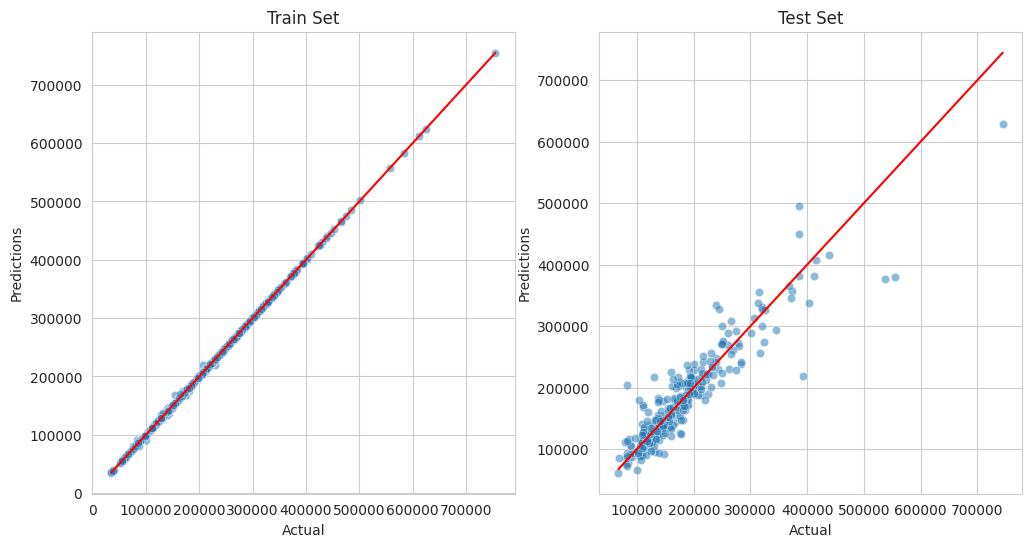

In [19]:
regression_performance(X_train, y_train, X_test, y_test, best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_regressor_pipeline)

### Refit Pipeline with Best Feature

Following steps that we have performed we will re fit te pipeline with our best features.

In [23]:
best_features

['GarageArea', 'GrLivArea', 'OverallQual', 'TotalBsmtSF', 'YearBuilt']

In [32]:
def PipelineOptimization(model):
    pipeline_base = Pipeline([

        ("LogTransformer", vt.LogTransformer(
                            variables = ['GrLivArea'])),
        ("PowerTransformer", vt.PowerTransformer(
                            variables = ['TotalBsmtSF'])),
        ("YeoJohnsonTransformer", vt.YeoJohnsonTransformer(
                            variables = ['TotalBsmtSF'])),

        ("model", model),
    ])

    return pipeline_base

In [33]:
X_train, X_test, y_train, y_test = train_test_split(
                                    df.drop(['SalePrice'], axis=1),
                                    df['SalePrice'],
                                    test_size = 0.2,
                                    random_state = 0,
                                    )

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1168, 20) (1168,) (292, 20) (292,)


In [34]:
X_train = X_train.filter(best_features)
X_test = X_test.filter(best_features)


print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1168, 5) (1168,) (292, 5) (292,)


In [35]:
models_search = {'ExtraTreesRegressor': ExtraTreesRegressor(random_state=0)}
models_search

{'ExtraTreesRegressor': ExtraTreesRegressor(random_state=0)}

In [36]:
params_search = {'ExtraTreesRegressor':   {
    'model__max_depth': [None],
    'model__min_samples_leaf': [1],
    'model__min_samples_split': [2],
    'model__n_estimators': [50]},
}
params_search

{'ExtraTreesRegressor': {'model__max_depth': [None],
  'model__min_samples_leaf': [1],
  'model__min_samples_split': [2],
  'model__n_estimators': [50]}}

In [37]:
quick_search = HyperparameterOptimizationSearch(
models=models_search, params=params_search)
quick_search.fit(X_train, y_train,scoring= 'r2',n_jobs=-1, cv=5)


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [38]:
grid_search_summary, grid_search_pipelines = quick_search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__min_samples_leaf,model__min_samples_split,model__n_estimators
0,ExtraTreesRegressor,0.704606,0.822851,0.877549,0.061761,None,1,2,50


In [40]:
best_model = grid_search_summary.iloc[0,0]
best_model

'ExtraTreesRegressor'

In [41]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('LogTransformer', LogTransformer(variables=['GrLivArea'])),
                ('PowerTransformer',
                 PowerTransformer(variables=['TotalBsmtSF'])),
                ('YeoJohnsonTransformer',
                 YeoJohnsonTransformer(variables=['TotalBsmtSF'])),
                ('model',
                 ExtraTreesRegressor(n_estimators=50, random_state=0))])

* These are the 5 most important features in descending order. The model was trained on them: 
['OverallQual', 'GrLivArea', 'TotalBsmtSF', 'YearBuilt', 'GarageArea']


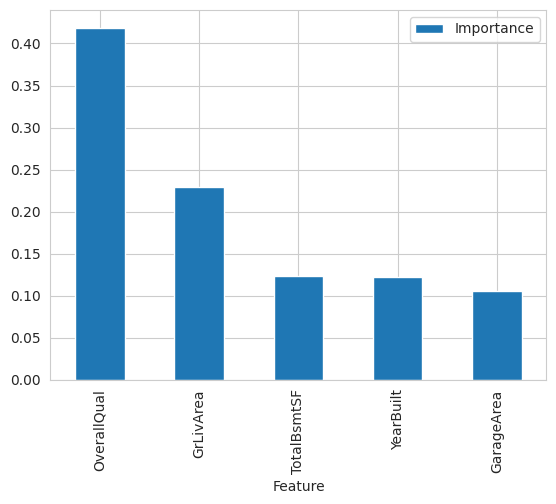

In [42]:
data_cleaning_feat_eng_steps = 1
columns_after_data_cleaning_feat_eng = (Pipeline(best_regressor_pipeline.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
        'Feature': columns_after_data_cleaning_feat_eng,
        'Importance': best_regressor_pipeline['model'].feature_importances_})
.sort_values(by='Importance', ascending=False)
)

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
    f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.show()

### Final Evaluation of Pipeline

Model Evaluation 

* Train Set
R2 Score: 1.0
Mean Absolute Error: 150.703
Mean Squared Error: 1008605.819
Root Mean Squared Error: 1004.294


* Test Set
R2 Score: 0.856
Mean Absolute Error: 19959.489
Mean Squared Error: 997606048.563
Root Mean Squared Error: 31584.902




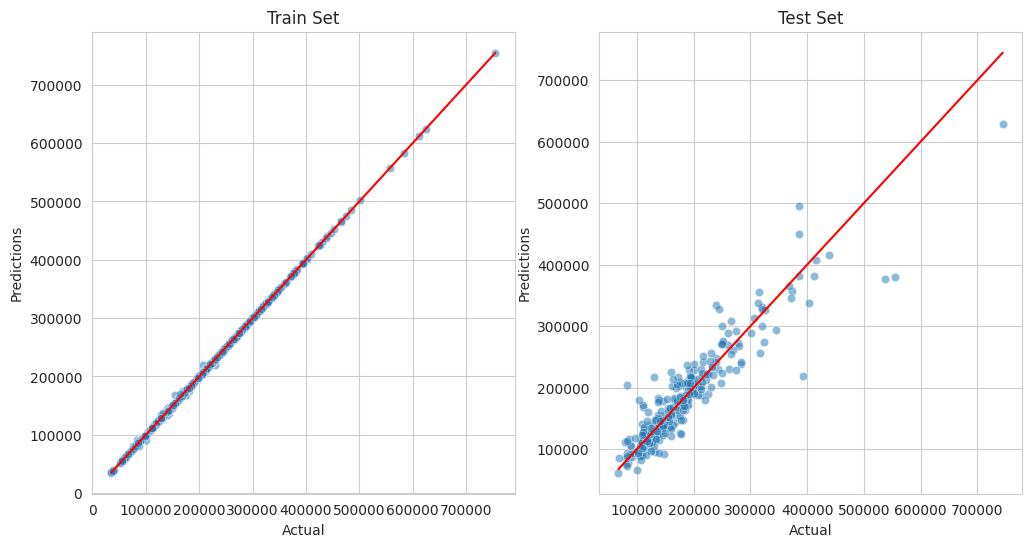

In [43]:

regression_performance(X_train, y_train, X_test, y_test, best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_regressor_pipeline)

## Push Files to Repo

We now need to save the following for our app:

* Traing set
* Testing set
* Modelling pipeline
* Features importance plot

In [44]:
import joblib
import os

version = 'v1'
file_path = f'outputs/ml_pipeline/predict_saleprice/{version}'

try:
    os.makedirs(name=file_path)
except Exception as e:
    print(e)

[Errno 17] File exists: 'outputs/ml_pipeline/predict_saleprice/v1'


### Training set

In [45]:
X_train.head()

,GarageArea,GrLivArea,OverallQual,TotalBsmtSF,YearBuilt
618,774,1828,9,1822,2007
870,308,894,5,894,1962
92,432,964,5,876,1921
817,857,1689,8,1568,2002
302,843,1541,7,1541,2001


In [46]:
X_train.to_csv(f"{file_path}/X_train.csv", index=False)

In [47]:
y_train

618     314813
870     109500
92      163500
817     271000
302     205000
         ...  
763     337000
835     128000
1216    112000
559     234000
684     221000
Name: SalePrice, Length: 1168, dtype: int64

In [48]:
y_train.to_csv(f"{file_path}/y_train.csv", index=False)

### Testing Set

In [49]:
X_test.head()

,GarageArea,GrLivArea,OverallQual,TotalBsmtSF,YearBuilt
529,484,2515,6,2035,1957
491,240,1578,6,806,1941
459,352,1203,5,709,1950
279,505,2022,7,1160,1977
655,264,1092,6,525,1971


In [50]:
X_test.to_csv(f"{file_path}/X_test.csv", index=False)

In [51]:
y_test

529     200624
491     133000
459     110000
279     192000
655      88000
         ...  
326     324000
440     555000
1387    136000
1323     82500
61      101000
Name: SalePrice, Length: 292, dtype: int64

In [52]:
y_test.to_csv(f"{file_path}/y_test.csv", index=False)

Modellling Pipeline 

In [53]:
best_regressor_pipeline

Pipeline(steps=[('LogTransformer', LogTransformer(variables=['GrLivArea'])),
                ('PowerTransformer',
                 PowerTransformer(variables=['TotalBsmtSF'])),
                ('YeoJohnsonTransformer',
                 YeoJohnsonTransformer(variables=['TotalBsmtSF'])),
                ('model',
                 ExtraTreesRegressor(n_estimators=50, random_state=0))])

In [54]:
joblib.dump(value=best_regressor_pipeline, filename=f"{file_path}/best_regressor_pipeline.pkl")

['outputs/ml_pipeline/predict_saleprice/v1/best_regressor_pipeline.pkl']

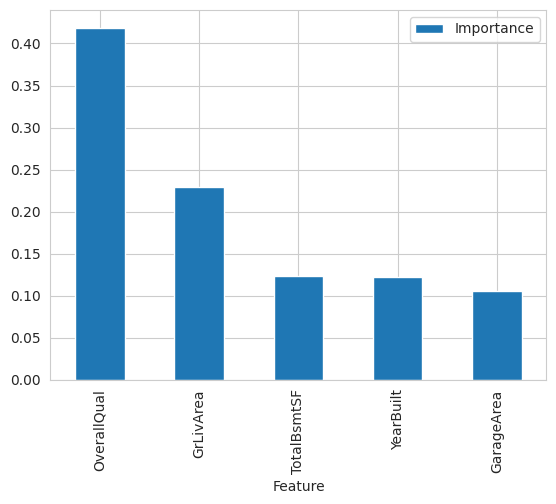

In [56]:
df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.savefig(f'{file_path}/features_importance.png', bbox_inches='tight')

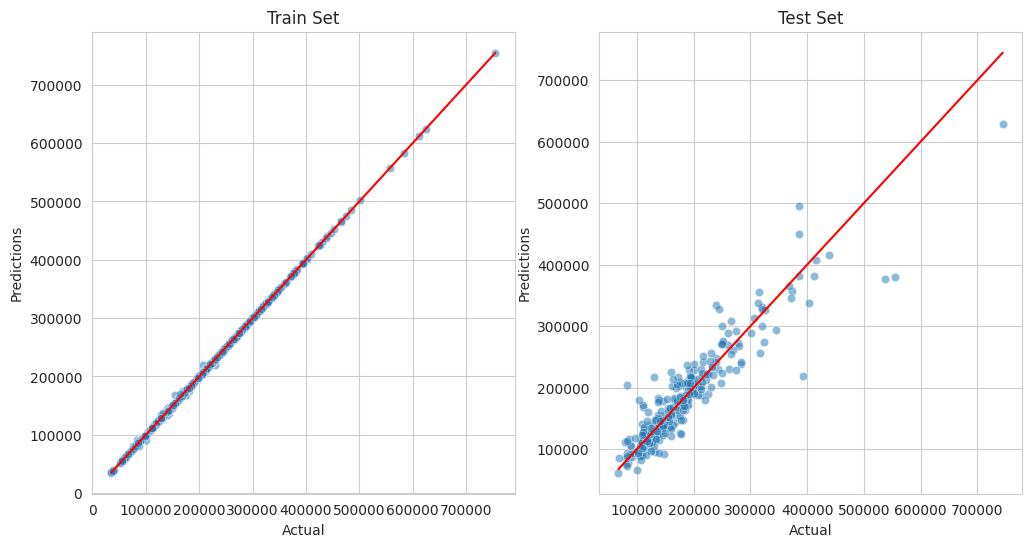

In [57]:
# regression_evaluation_plots(X_train, y_train, X_test, y_test, best_regressor_pipeline)
pred_train = best_regressor_pipeline.predict(X_train)
pred_test = best_regressor_pipeline.predict(X_test)
alpha_scatter=0.5

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
sns.scatterplot(x=y_train , y=pred_train, alpha=alpha_scatter, ax=axes[0])
sns.lineplot(x=y_train , y=y_train, color='red', ax=axes[0])
axes[0].set_xlabel("Actual")
axes[0].set_ylabel("Predictions")
axes[0].set_title("Train Set")

sns.scatterplot(x=y_test , y=pred_test, alpha=alpha_scatter, ax=axes[1])
sns.lineplot(x=y_test , y=y_test, color='red', ax=axes[1])
axes[1].set_xlabel("Actual")
axes[1].set_ylabel("Predictions")
axes[1].set_title("Test Set")

plt.savefig(f'{file_path}/regression_evaluation_plots.png', bbox_inches='tight')

## Conclusion

* The ExtraTreesregressor model has been chosen to predict the sale price for a given property.
* The model scored the R2 Score: 1.00 on the train set, and the test set has scored on R2 Score 0.856 which is greater than the required an R2 score of 0.75+.